# Module 3 - Wrap-Up Quiz

## Importing Data

In [1]:
import pandas as pd

penguins = pd.read_csv("../datasets/penguins.csv")

columns = ["Body Mass (g)", "Flipper Length (mm)", "Culmen Length (mm)"]
target_name = "Species"

# Remove lines with missing values for the columns of interest
penguins_non_missing = penguins[columns + [target_name]].dropna()

data = penguins_non_missing[columns]
target = penguins_non_missing[target_name]

## Checking Target

In [2]:
target.value_counts(normalize=True)

Species
Adelie Penguin (Pygoscelis adeliae)          0.441520
Gentoo penguin (Pygoscelis papua)            0.359649
Chinstrap penguin (Pygoscelis antarctica)    0.198830
Name: proportion, dtype: float64

We observe that there are 3 classes, thus the problem is a multiclass problem. We also observe that there are more than twice as many Adelie Penguins as there are Chinstrap penguins in this dataset.

## Checking Features

In [4]:
data.describe()

,Body Mass (g),Flipper Length (mm),Culmen Length (mm)
count,342.000000,342.000000,342.000000
mean,4201.754386,200.915205,43.921930
std,801.954536,14.061714,5.459584
min,2700.000000,172.000000,32.100000
25%,3550.000000,190.000000,39.225000
50%,4050.000000,197.000000,44.450000
75%,4750.000000,213.000000,48.500000
max,6300.000000,231.000000,59.600000


We observe that the body mass varies between 2700 g and 6300 g with a standard deviation of 801 g while the length of the culmen varies between 5 mm and 59.6 mm with a standard deviation of 5 mm. Therefore, if we use the default units, the features do not have the same dynamic range at all.

## Model

Let's now consider the following pipeline:

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
model = Pipeline(steps=[
    ("preprocessor", StandardScaler()),
    ("classifier", KNeighborsClassifier(n_neighbors=5)),
])

and evaluate the pipeline using stratified 10-fold cross-validation with the balanced-accuracy scoring metric to choose the correct statement in the list below.

In [3]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target, cv=10, scoring="balanced_accuracy")

scores_5 = cv_results["test_score"]

print(
    "The mean cross-validation test accuracy is: "
    f"{scores_5.mean():.3f} ± {scores_5.std():.3f} "
)

The mean cross-validation test accuracy is: 0.952 ± 0.040 


In [17]:
print(scores_5)

[1.         1.         1.         0.91880342 0.88253968 0.95238095
 0.97777778 0.93015873 0.90793651 0.95238095]


The cross-validated scores give values between 0.88 and 1.0 with an average close to 0.95.

## Manual Parameter Search

We repeat the evaluation while manually changing the parameters. One way to compare two models is comparing the cross-validation test scores of both models fold-to-fold, i.e. counting the number of folds where one model has a better test score than the other.

### n_neighbors = 51

In [18]:
model.set_params(classifier__n_neighbors=51)

cv_results = cross_validate(model, data, target, cv=10, scoring="balanced_accuracy")

scores_51 = cv_results["test_score"]

print(
    "The mean cross-validation test accuracy is: "
    f"{scores_51.mean():.3f} ± {scores_51.std():.3f} "
)

The mean cross-validation test accuracy is: 0.942 ± 0.039 


The mean cross-validation gives slightly worse test scores but the difference is not necessarily significant: they overlap a lot. So given the definition of better, we can check the individual score for each fold and count how many times the 5-NN classifier is better than the 51-NN classifier. With some python code (you could have do it by visualizing the "test_score" columns as well), we obtain:

In [30]:
print(scores_51)
# count the cases where the scores for 51 are bigger than 5
(scores_5 > scores_51).sum()

[0.95238095 0.97777778 1.         0.86324786 0.88253968 0.95238095
 0.95555556 0.95238095 0.93015873 0.95238095]


4

Here, 5-NN is strictly better than 51-NN only 4 times and thus we cannot conclude that it is substantially better.

### n_neighbors = 101

In [22]:
model.set_params(classifier__n_neighbors=101)

cv_results = cross_validate(model, data, target, cv=10, scoring="balanced_accuracy")

scores_101 = cv_results["test_score"]

print(
    "The mean cross-validation test accuracy is: "
    f"{scores_101.mean():.3f} ± {scores_101.std():.3f} "
)

The mean cross-validation test accuracy is: 0.877 ± 0.042 


We observe that the average test accuracy of this last model seems to be substantially lower that the previous models. Let's check the number of CV folds where this is actually the case:

In [29]:
print(scores_101)
# count the cases where the scores for 51 are bigger than 5
# we can also sort before comparing...
(scores_5 > scores_101).sum()

[0.85714286 0.95238095 0.94444444 0.86324786 0.83492063 0.85714286
 0.83492063 0.88253968 0.83492063 0.9047619 ]


10

In this case, we observe that 5-NN is always better.

### Without StandardScaler

It is possible to change the pipeline parameters and re-run a cross-validation with:

```Python
model.set_params(preprocessor=StandardScaler(), classifier__n_neighbors=51)
```

And, we can disable the preprocessor by setting the preprocessor parameter to `None` (while resetting the number of neighbors to 5) as follows:

```Python
model.set_params(preprocessor=None, classifier__n_neighbors=5)
```

In [4]:
model_2 = KNeighborsClassifier(n_neighbors=5)

cv_results = cross_validate(model_2, data, target, cv=10, scoring="balanced_accuracy")

scores_woss = cv_results["test_score"]

print(
    "The mean cross-validation test accuracy is: "
    f"{scores_woss.mean():.3f} ± {scores_woss.std():.3f} "
)

The mean cross-validation test accuracy is: 0.740 ± 0.087 


This gives results with a mean balanced accuracy of ~0.74 which is much worse than the same result with preprocessing enabled. We can confirm that preprocessing the dataset lead to a substantially better model:

In [5]:
print(scores_woss)
(scores_5 > scores_woss).sum()

[0.66468254 0.73601954 0.74102564 0.7042735  0.58412698 0.66984127
 0.83492063 0.74285714 0.88253968 0.83809524]


10

Here, the model with feature scaling is performing better 10 times over 10 than the model that does not preprocess the dataset.

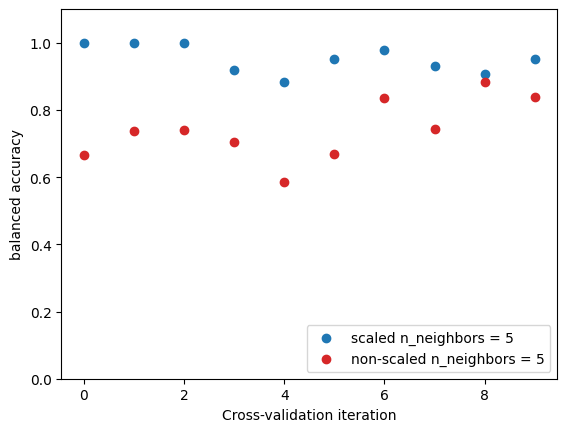

In [8]:
import matplotlib.pyplot as plt

indices = list(range(len(scores_5)))

plt.scatter(
    indices,
    scores_5,
    color="tab:blue",
    label="scaled n_neighbors = 5"
)

plt.scatter(
    indices,
    scores_woss,
    color="tab:red",
    label="non-scaled n_neighbors = 5",
)

plt.ylim((0, 1.1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("balanced accuracy")
_ = plt.legend(loc="lower right")

## Preprocessing Impact

We will now study the impact of different preprocessors defined in the list below:

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


all_preprocessors = [
    None,
    StandardScaler(),
    MinMaxScaler(),
    QuantileTransformer(n_quantiles=100),
    PowerTransformer(method="box-cox"),
]

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {"preprocessor": all_preprocessors, "classifier__n_neighbors": [5, 51, 101]}

model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=10, verbose=1, scoring = "balanced_accuracy")

model_grid_search.fit(data, target)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=2,
             param_grid={'classifier__n_neighbors': [5, 51, 101],
                         'preprocessor': [None, StandardScaler(),
                                          MinMaxScaler(),
                                          QuantileTransformer(n_quantiles=100),
                                          PowerTransformer(method='box-cox')]},
             scoring='balanced_accuracy', verbose=1)

In [11]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "rank_test_score", ascending=True, ignore_index=True)
# convert the name of the preprocessor for later display. The name is an object by default.
cv_results["param_preprocessor"] = cv_results["param_preprocessor"].apply(
    lambda x: x.__class__.__name__ if x is not None else "None"
)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_neighbors,param_preprocessor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003514,0.000500,0.004831,0.000712,5,StandardScaler,"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,1.000000,1.0,0.918803,0.882540,0.952381,0.977778,0.930159,0.907937,0.952381,0.952198,0.039902,1
1,0.003860,0.000756,0.004068,0.000360,5,MinMaxScaler,"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,0.952381,1.0,0.944444,0.882540,0.930159,0.955556,0.952381,0.907937,0.952381,0.947778,0.034268,2
2,0.004363,0.000618,0.004765,0.000869,5,QuantileTransformer,"{'classifier__n_neighbors': 5, 'preprocessor':...",0.952381,0.926740,1.0,0.918803,0.904762,1.000000,0.977778,0.930159,0.907937,0.952381,0.947094,0.033797,3
3,0.007659,0.001771,0.005152,0.001053,5,PowerTransformer,"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,0.977778,1.0,0.863248,0.882540,0.952381,0.955556,0.930159,0.907937,1.000000,0.946960,0.047387,4
4,0.003732,0.000755,0.004838,0.000673,51,StandardScaler,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.952381,0.977778,1.0,0.863248,0.882540,0.952381,0.955556,0.952381,0.930159,0.952381,0.941880,0.038905,5


We see that the best model uses a `StandardScaler` while the subsequent three models are using the other preprocessors. We can thus check if `StandardScaler` is performing substantially better than the other models.

##### The best ranked model using a `StandardScaler` is substantially better (at least 7 of the cross-validations scores are better) than using any other preprocessor?

In [12]:
reference_model = cv_results.iloc[0]
other_models = cv_results.iloc[1:4]
cv_score_columns = cv_results.columns[cv_results.columns.str.startswith("split")]
for idx, other_model in other_models.iterrows():
    score_reference_model = reference_model[cv_score_columns]
    score_other_model = other_model[cv_score_columns]
    print(
        f"{reference_model['param_classifier__n_neighbors']}-NN with "
        f"{reference_model['param_preprocessor']} is strictly better than "
        f"{other_model['param_classifier__n_neighbors']}-NN with "
        f"{other_model['param_preprocessor']} for "
        f"{sum(score_reference_model > score_other_model)} CV iterations "
        f"out of 10."
    )

5-NN with StandardScaler is strictly better than 5-NN with MinMaxScaler for 3 CV iterations out of 10.
5-NN with StandardScaler is strictly better than 5-NN with QuantileTransformer for 2 CV iterations out of 10.
5-NN with StandardScaler is strictly better than 5-NN with PowerTransformer for 3 CV iterations out of 10.


Thus, a 5-NN model with a `StandardScaler` does not perform substantially better than the models that use alternative scaling strategies.

Looking at the ranking, we see that not applying any preprocessing always lead to the worst results. The main reason that explains that removing the preprocessor leads to bad performance, is the fact that the input features have very different dynamic ranges when using the default units (grams and millimeters).

We can also visualize the cross-validation scores:

5-NN with StandardScaler is strictly better than 5-NN with MinMaxScaler for 3 CV iterations out of 10.
5-NN with StandardScaler is strictly better than 5-NN with QuantileTransformer for 2 CV iterations out of 10.
5-NN with StandardScaler is strictly better than 5-NN with PowerTransformer for 3 CV iterations out of 10.


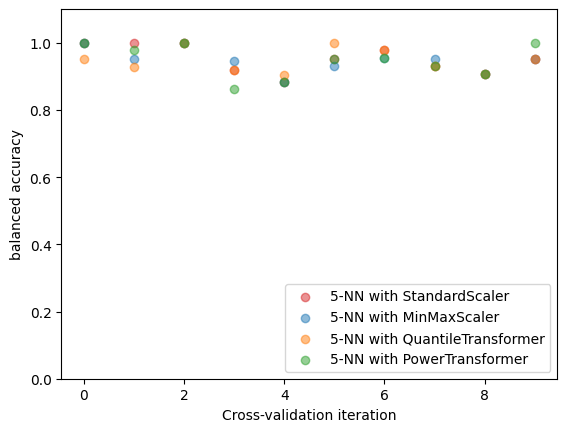

In [16]:
reference_model = cv_results.iloc[0]
other_models = cv_results.iloc[1:4]
cv_score_columns = cv_results.columns[cv_results.columns.str.startswith("split")]
score_reference_model = reference_model[cv_score_columns]

fig, ax = plt.subplots()
ax.scatter(
    indices,
    score_reference_model,
    color="tab:red",
    alpha=0.5,
    label=f"{reference_model['param_classifier__n_neighbors']}-NN with "
          f"{reference_model['param_preprocessor']}",
)

for idx, other_model in other_models.iterrows():
    score_other_model = other_model[cv_score_columns]
    ax.scatter(
    indices,
    score_other_model,
    alpha=0.5,
    label=f"{other_model['param_classifier__n_neighbors']}-NN with "
          f"{other_model['param_preprocessor']}",
    )
    print(
        f"{reference_model['param_classifier__n_neighbors']}-NN with "
        f"{reference_model['param_preprocessor']} is strictly better than "
        f"{other_model['param_classifier__n_neighbors']}-NN with "
        f"{other_model['param_preprocessor']} for "
        f"{sum(score_reference_model > score_other_model)} CV iterations "
        f"out of 10."
    )
ax.set_ylim((0, 1.1))
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("balanced accuracy")
_ = ax.legend(loc="lower right")

##### The model with `n_neighbors=5` and `StandardScaler` is substantially better (at least 7 of the cross-validations scores are better) than the model with `n_neighbors=51` and `StandardScaler`?

Now, we can fix the preprocessor to `StandardScaler` and check the impact of the number of neighbors on the score.

In [14]:
import numpy as np

reference_model = cv_results.iloc[0][cv_score_columns]
other_model = cv_results.iloc[4][cv_score_columns]
print(
    f"5-NN with StandardScaler is strictly better than 51-NN with StandardScaler for "
    f"{np.sum(reference_model.to_numpy() > other_model.to_numpy())} "
    "CV iterations out of 10."
)

5-NN with StandardScaler is strictly better than 51-NN with StandardScaler for 4 CV iterations out of 10.


Thus, 5-NN is not substantially better 51-NN when the preprocessor is fixed to a `StandardScaler`.

##### The model with n_neighbors=51 and StandardScaler is substantially better (at least 7 of the cross-validations scores are better) than the model with n_neighbors=101 and StandardScaler?

We can repeat the same process to compare the 51-NN and 101-NN:

In [15]:
reference_model = cv_results.iloc[0][cv_score_columns]
other_model = cv_results.iloc[8][cv_score_columns]
print(
    f"51-NN with StandardScaler is strictly better than 101-NN with StandardScaler for "
    f"{np.sum(reference_model.to_numpy() > other_model.to_numpy())} "
    "CV iterations out of 10."
)

51-NN with StandardScaler is strictly better than 101-NN with StandardScaler for 10 CV iterations out of 10.


In this case, we observe that 51-NN is substantially better than the 101-NN.

As explained previously, setting a too large value for n_neighbors causes under-fitting. Here the data is well structured and has not much noise: using low values for n_neighbors is as good or better than intermediate values as there is not much over-fitting possible.

## Nested Cross-Validation

#### The nested cross-validation scores can be computed with:

In [86]:
cv_results = cross_validate(
    model_grid_search, data, target, cv=10, n_jobs=2, return_estimator=True, scoring = "balanced_accuracy"
)

In [87]:
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results["test_score"]
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} ± {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.943 ± 0.038


which gives values between 0.92 and 1.0 with an average close to 0.94. The nested cross-validation scores overlaps with the scores observed in the inner grid-search which means that the hyperparameter tuning procedure itself does not cause significant overfitting. Note however that the standard deviation of the cross-validation scores is very large because the dataset is small. The use of nested cross-validation itself will be explored more in detail in the module on model evaluation.

#### Best estimators

The best parameters found by the grid search models on the different folds can be accessed with:

In [88]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
Best hyperparameters for fold #2:
{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
Best hyperparameters for fold #3:
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
Best hyperparameters for fold #4:
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
Best hyperparameters for fold #5:
{'classifier__n_neighbors': 5, 'preprocessor': MinMaxScaler()}
Best hyperparameters for fold #6:
{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
Best hyperparameters for fold #7:
{'classifier__n_neighbors': 5, 'preprocessor': MinMaxScaler()}
Best hyperparameters for fold #8:
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
Best hyperparameters for fold #9:
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
Best hyperparameters for fold #10:
{'classifier__n_ne

which gives 'classifier__n_neighbors': 5 for (almost) all of the folds, but the optimal scaler selected by the grid search depends on the training subsample of data. This confirms that 5-NN model is the best regardless of the scaler, as long as the data is reasonably scaled.